# South African Language Identification

© Explore Data Science Academy Hackathon 2022

---

## 1.0 Overview

<img src="images/banner.jpg"/>

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages. With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

---

## 2.0 Importing Packages

In [ ]:
# data loading and manipulation packages
import pandas as pd
from nltk import tokenize
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# data Visualisation Packages
import seaborn as sns
import matplotlib.pyplot as plt

# data modeling and evaluation packages
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn import pipeline
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

For this project, three distinct packages were used; Pandas - for reading and manipulating the datasets, nltk - for natural language processing and sklearn for modeling and evaluation. <br ><br >

## 2.0 Loading Datasets

In [ ]:
# read the training dataset
df_train = pd.read_csv('data/train_set.csv')

# read the testing dataset
df_test = pd.read_csv('data/test_set.csv')

The datasets for this project is included in the data subfolder of this notebook. <br><br>

## 3.0 Exploratory Data Analysis

Exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. Primarily, EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.This approach for data analysis uses many tools(mainly graphical to maximize insight into a data set, extract important variables, detect outliers and anomalies, amongst other details that is missed when looking at DataFrame. This step is very important especially when we model the data in order to apply Machine Learning techniques.

### 3.1 Overview of the Training Dataset

In [ ]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


A quick snapshot of the dataset indicates that the dataset contains a single predictor; text with a target variable; lang_id. From the above snapshot, it is not obvious the cleanliness status of the dataset. <br ><br >

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  20761 non-null  object
 1   text     20761 non-null  object
dtypes: object(2)
memory usage: 324.5+ KB


The dataset is free of nulls. The shape of the dataset can also be deduced to be (33000 x 2). No cleanings required in terms of missing values. <br><br>

**Summary of Observations:**
* The train dataset has 33000 rows
* The train dataset contains two features
* both features are categorical - 'text' and 'lang_id'
* No special characters were immediately visible execpt '-' used in joining multi-words 

### 3.2 Analysis of the Target Feature

#### 3.2.1 Language Distribution

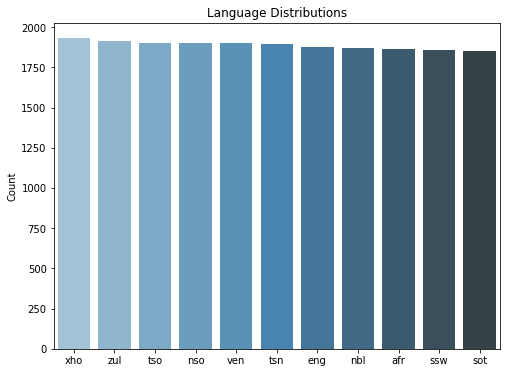

In [ ]:
# Count occurence of each class in training dataset
category_counts = df_train['lang_id'].value_counts()
category_counts

'''
    Calculate the number of texts per language 
    and plot the class distributions results
'''

fig, ax = plt.subplots(figsize = (8, 6))
target =df_train['lang_id'].value_counts()
sns.barplot(x=target.index, y=target, ax=ax, palette="Blues_d")
plt.title('Language Distributions')
plt.ylabel("Count")
plt.show()

The training dataset has balanced classes. The implication of using this training dataset will be the creation of a model whose identification of each language is unbiased. For an instance, every language have equal chances of being identified<br><br>

#### 3.3 Analysis  of the Message feature

##### 3.3.1 Distinct Words

In this section, the size of the train dataset in terms of total numbers of words and total number of non-reeating words is inspected. This is to ensure that the words in the dataset are repeated enough to be useful and are unique enough for each language to enable their identification.

In [ ]:
 def create_bank_set(dataset, word="", category=""):
    '''
        Creates a list of all the words or characters in the text feature
        
        Input:
            dataset - The dataset to extract words or characters from
            category - Filters the dataset by the specified category
            type - Specifies the level of extraction; wether characters or words
        
        Output:
            pandas DataFrame of all the characters or words of the specified category 
    '''
    corpus = []
    if category:
        df = dataset[dataset['lang_id'] == category]['text']
    else:
        df = dataset['text']
    
    if word:
        bank = []
        for row in df:
            bank.extend(row.split(" "))
    else:
        bank = [row[x] for row in df for x in range(len(row))]
        
    return pd.DataFrame(bank)

<br />
Using the create_bank_set function to create a word bank for the entire train dataset

In [ ]:
words = create_bank_set(df_train, word=True)
total_words = len(words[0])
count_unique = len(words[0].unique())
print("Total words: {} \nDistinct words: {}".format(total_words, count_unique))
print("A word is repeated an average of: {} times".format(total_words / count_unique))

Total words: 771189 
Distinct words: 111655
A word is repeated an average of: 6.906891764811249 times


#### 3.4 Words Common to more than One Language

Some languages share words spelt similarly with words in other languages. Although, such words might not have same meaning in both languages. Do south African languages have such characteristics?

In [ ]:
languages = df_train['lang_id'].unique()
dict_index = []
dict_value = []
for language in languages:
    lang_words = set(create_bank_set(df_train, word="True", category=language)[0])
    all_words = set(create_bank_set(df_train[df_train['lang_id'] != language], word="True")[0])
    dict_index.append(language)
    dict_value.append(len(lang_words.intersection(all_words)))
    
common = pd.DataFrame(dict_value, index=dict_index)

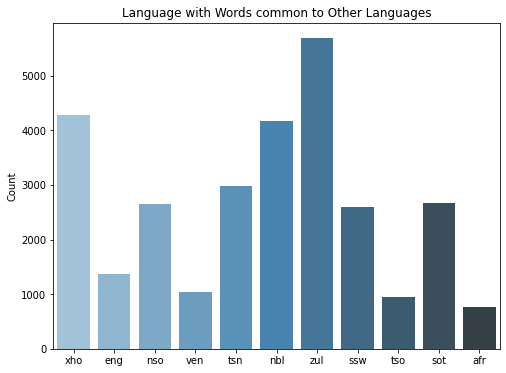

In [ ]:

fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(x=common.index, y=common[0], ax=ax, palette="Blues_d")
plt.title('Language with Words common to Other Languages')
plt.ylabel("Count")
plt.show()

Zulu has the most shared words by other languages in the dataset. The implication of this is that, models will find it harder to accurately identify the Zulu language. <br ><br>

#### 3.4.1 Languages with the most unique words

In [ ]:
languages = df_train['lang_id'].unique()
dict_index = []
dict_value = []
for language in languages:
    lang_words = set(create_bank_set(df_train, word="True", category=language)[0])
    all_words = set(create_bank_set(df_train[df_train['lang_id'] != language], word="True")[0])
    dict_index.append(language)
    dict_value.append(len(lang_words.difference(all_words)))
    
unique = pd.DataFrame(dict_value, index=dict_index)
unique.sum()

0    99983
dtype: int64

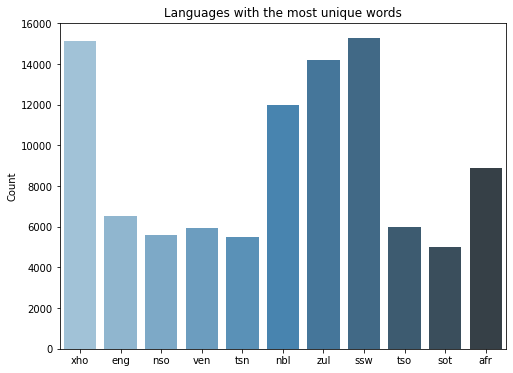

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(x=unique.index, y=unique[0], ax=ax, palette="Blues_d")
plt.title('Languages with the most unique words')
plt.ylabel("Count")
plt.show()

All the laguages are equally distributed in the training dataset, yet, inspite of Zulu having the most shared words among teh languages, it still ranks amongs languages with the most unique words. Hence, it can only mean that most Zulu texts contain more number of words compared to the other languages.<br><br>

#### 3.4.2 Average Number Of Words Per text for each feature

In [ ]:
languages = df_train['lang_id'].unique()
dict_index = []
dict_value = []
for language in languages:
    lang_words = len(list(create_bank_set(df_train, word="True", category=language)[0])) / df_train.shape[0]
    dict_index.append(language)
    dict_value.append(lang_words)
    
avg = pd.DataFrame(dict_value, index=dict_index)

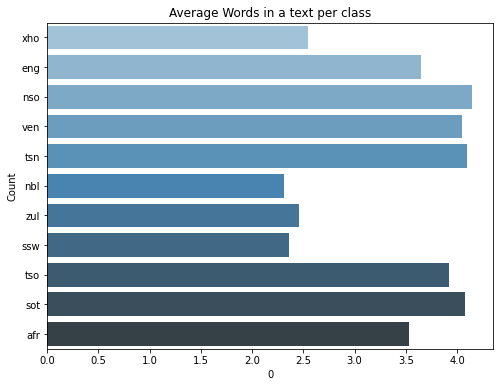

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.barplot(x=avg[0], y=avg.index, ax=ax, palette="Blues_d")
plt.title('Average Words in a text per class')
plt.ylabel("Count")
plt.show()

Surprising that ZUlu ranks among the lowest in terms of words per text. <br><br>

## 4.0 Data Cleaning and Engineering

In this section, the recommendations from the exploratory data analysis phase is implemented. The dataset was cleaned and features engineered from the message field.

### 4.1 Text Cleaning

The dataset contains punctuations and numbers. Words also exist in different cases which models might translate different. Hence, the proceeding function performs cleaning by:
- Remove punctuations
- Change  Case to lower case

In [ ]:
def clean_data(text):
    # change the case of all the words in the text to lowercase 
    text = text.lower()
    
    # remove punctuation
    text = "".join([x for x in text if x not in string.punctuation])
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    return text

In [ ]:
# Clean the train dataset
df_train['text'] = df_train['text'].apply(clean_data)

# Clean the test dataset
df_test['text'] = df_test['text'].apply(clean_data)

df_train.head()

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


### 4.2 Split Dataset into Training and Validation set

To properly assess a model, we need to assess the model on data which it has not seen before. Hence, there is a need to split the training dataset into two different datasets; the training dataset - which will be used to train a model and the validation set - which will be used to measure the performance of the model. 

In [ ]:
train_x, validation_x, train_y, validation_y = train_test_split(df_train['text'], 
                                                                df_train['lang_id'], 
                                                                test_size=0.2,  
                                                                random_state=20)

## 5.0 Data Modeling and Evaluation

### 5.1 Feature Extraction (Vectorization)

To create a model, there is a need to have a set of feature(s) and target. Most models only accept numerical values for feature sets. For this project, our feature is a string of words. Hence there is a need to create vectors of digits from these words. The process is called Vectorization.

For this project we define a vectorizer with the following tuning
- ngram_range = (4, 8)
- max_df = 0.7
- min_df = 3

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(4,8), 
                             analyzer='char', 
                             min_df=5, 
                             max_df = 0.7)

### 5.2 Modeling Function

The function defined below can be used to create, vectorize and train a model using a pipeline. The function takes in the vectorizer class, the model to use and the train datasets as arguments and returns a trained model instance.

In [ ]:
def create_model(vectorizer, model, x_train, y_train): 
    model = pipeline.Pipeline([
        ('vectorizer', vectorizer),
        ('clf', model())
    ])
    return model.fit(x_train,y_train)

The function below can be used to evaluate a model on avalidation set. The function takes in the trained model and the validation sets as arguments and returns the classification report.

In [ ]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(classification_report(y_test,y_pred))

### 5.3  Training and Evaluating Models

#### Logistic Regressor

In [ ]:
lgr_model = create_model(vectorizer, LogisticRegression, train_x, train_y)
evaluate(lgr_model, validation_x, validation_y)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       386
         eng       1.00      1.00      1.00       362
         nbl       1.00      0.99      1.00       400
         nso       1.00      1.00      1.00       396
         sot       1.00      1.00      1.00       354
         ssw       1.00      1.00      1.00       350
         tsn       1.00      1.00      1.00       370
         tso       1.00      1.00      1.00       409
         ven       1.00      1.00      1.00       380
         xho       1.00      1.00      1.00       359
         zul       0.99      1.00      1.00       387

    accuracy                           1.00      4153
   macro avg       1.00      1.00      1.00      4153
weighted avg       1.00      1.00      1.00      4153



The considered problem is high dimentional (many features) and high dimensional problems are likely to be linearly separable meaning the different point can be seperated with a linear classifier, regardless of how the points are labelled. So linear classifiers like ridge regression or SVM with a linear kernel, are likely to do well. The logistic Regression model is a linear model for both regression and classification problems. Logistic regression classifies events by calculating the probability of the event occurring. For this use case, the model achieves a perfect accuracy, although it returns a precision of 99% for the zulu language; meaning that the models classifies some test samples which are not Zulu to be Zulu (False Positive). This result has been forecasted from the EDA because the Zulu language has the most words common to other languages.

#### Ridge Regressor

In [ ]:
ridge_model = create_model(vectorizer, RidgeClassifier, train_x, train_y)
evaluate(ridge_model, validation_x, validation_y)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       386
         eng       1.00      1.00      1.00       362
         nbl       1.00      1.00      1.00       400
         nso       1.00      1.00      1.00       396
         sot       1.00      1.00      1.00       354
         ssw       1.00      1.00      1.00       350
         tsn       1.00      1.00      1.00       370
         tso       1.00      1.00      1.00       409
         ven       1.00      1.00      1.00       380
         xho       1.00      1.00      1.00       359
         zul       1.00      1.00      1.00       387

    accuracy                           1.00      4153
   macro avg       1.00      1.00      1.00      4153
weighted avg       1.00      1.00      1.00      4153



Since, a linear classifier did very well, the ridge classifier was considered. The Ridge Classifier is also a linear model which builds on the Linear regressor to improve performance. Hence, the choice to implement the Ridge Classifier. The result was perfect.

#### Stochastic Gradient Descent  Classifier (SGD-Classifier)

In [ ]:
sgdc_model = create_model(vectorizer, SGDClassifier, train_x, train_y)
evaluate(sgdc_model, validation_x, validation_y)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       386
         eng       1.00      1.00      1.00       362
         nbl       1.00      1.00      1.00       400
         nso       1.00      1.00      1.00       396
         sot       1.00      1.00      1.00       354
         ssw       1.00      1.00      1.00       350
         tsn       1.00      1.00      1.00       370
         tso       1.00      1.00      1.00       409
         ven       1.00      1.00      1.00       380
         xho       1.00      1.00      1.00       359
         zul       1.00      1.00      1.00       387

    accuracy                           1.00      4153
   macro avg       1.00      1.00      1.00      4153
weighted avg       1.00      1.00      1.00      4153



This result is a confirmation that the data entries in this problem are very linearly seperable. That serves as the explanation for why the linear models are performing perfectly on the dataset.

#### K Nearest Neighbour

In [ ]:
knn_model = create_model(vectorizer, KNeighborsClassifier, train_x, train_y)
evaluate(knn_model, validation_x, validation_y)

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       386
         eng       1.00      1.00      1.00       362
         nbl       0.93      0.94      0.93       400
         nso       0.97      0.99      0.98       396
         sot       0.98      0.97      0.98       354
         ssw       0.93      0.97      0.95       350
         tsn       0.98      0.96      0.97       370
         tso       1.00      0.99      1.00       409
         ven       0.99      1.00      1.00       380
         xho       0.94      0.97      0.95       359
         zul       0.94      0.87      0.90       387

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153



Having considered models based on linear and unlinear layout of datapoints, an algorithms which based on an entirely different appraoch is considered. Hence, the K-Nearest Neighbor classifier is considered. The K-Nearest Neighbor classifier is a nonparametric classification method which uses plurality of vote of its neighbors for classification. K is the defined number of neighbors used in voting. As indicated by the report, this models performs less impressive than the linear models.